# Austin Bike Share Daily Rental Predictions
The goal of this project is to take data provided by Austin Bike Share from 2013 to 2017 and predict what the daily rentals will be at a given bike share station. The predictions will be tested on the provided data in 2017 and the training/validation will be done on the data for 2013-2016. 


## Preprocessing Data
data here will be preprocessed to get a good bird`s eye view of the trends and patterns. 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as sk # SkLearn ML library
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import seaborn as sns
import requests
from datetime import datetime

# Input data files are available in the "austin-bike" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "austin-bike"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

austin_bikeshare_stations.csv
austin_bikeshare_trips.csv
austin_weather.csv



In [14]:
# load data in 

trips = pd.read_csv('austin-bike/austin_bikeshare_trips.csv')
stations = pd.read_csv('austin-bike/austin_bikeshare_stations.csv')

In [103]:
trips.head()

,bikeid,checkout_time,duration_minutes,end_station_id,end_station_name,month,start_station_id,start_station_name,start_time,subscriber_type,trip_id,year,dayofweek
0,8.0,19:12:00,41,2565.0,Trinity & 6th Street,3.0,2536.0,Waller & 6th St.,2015-03-19 19:12:00,Walk Up,9900082882,2015.0,3
1,141.0,2:06:04,6,2570.0,South Congress & Academy,10.0,2494.0,2nd & Congress,2016-10-30 02:06:04,Local365,12617682,2016.0,6
2,578.0,16:28:27,13,2498.0,Convention Center / 4th St. @ MetroRail,3.0,2538.0,Bullock Museum @ Congress & MLK,2016-03-11 16:28:27,Local365,9075366,2016.0,4
3,555.0,15:12:00,80,2712.0,Toomey Rd @ South Lamar,11.0,2497.0,Capitol Station / Congress & 11th,2014-11-23 15:12:00,24-Hour Kiosk (Austin B-cycle),9900319298,2014.0,6
4,86.0,15:39:13,25,3377.0,MoPac Pedestrian Bridge @ Veterans Drive,4.0,2707.0,Rainey St @ Cummings,2017-04-16 15:39:13,Walk Up,14468597,2017.0,6


In [17]:
stations.head()

,latitude,location,longitude,name,station_id,status
0,30.27041,(30.27041 -97.75046),-97.75046,West & 6th St.,2537,active
1,30.26452,(30.26452 -97.7712),-97.77120,Barton Springs Pool,2572,active
2,30.27595,(30.27595 -97.74739),-97.74739,ACC - Rio Grande & 12th,2545,closed
3,30.28480,(30.2848 -97.72756),-97.72756,Red River & LBJ Library,1004,closed
4,30.26694,(30.26694 -97.74939),-97.74939,Nueces @ 3rd,1008,moved


## Station Analysis
this section will look at trends for the stations

In [76]:
# calculate the lifetime rentals of each station
start_station_usage = trips.start_station_name.value_counts()
print(start_station_usage[:10])

# count the number of stations that have been used
print("total stations that have had bikes rented from are: ", len(start_station_usage))

# count the number of lifetime rentals
print("total number of rentals in the dataset are: ", len(trips))

Riverside @ S. Lamar                       28695
City Hall / Lavaca & 2nd                   28535
5th & Bowie                                26669
2nd & Congress                             26612
4th & Congress                             24972
Convention Center / 4th St. @ MetroRail    24357
Rainey St @ Cummings                       23468
Davis at Rainey Street                     22273
Capitol Station / Congress & 11th          20056
Pfluger Bridge @ W 2nd Street              19434
Name: start_station_name, dtype: int64
total stations that have had bikes rented from are:  90
total number of rentals in the dataset are:  649231


## Day of Week Analysis

In [64]:
# calculate bike rentals by day of the week
import calendar
trips['dayofweek'] = pd.to_datetime(trips.start_time).dt.dayofweek

dayofweek_counts = trips.dayofweek.value_counts()

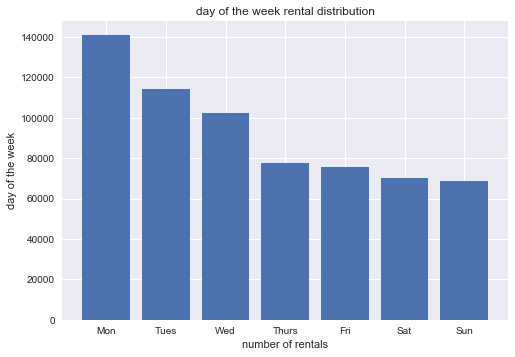

In [66]:
# plot the day of the week rental distribution
import matplotlib.pyplot as plt

daysofweek = ('Mon','Tues','Wed','Thurs','Fri','Sat','Sun')
y_pos = np.arange(len(daysofweek))
plt.bar(y_pos,dayofweek_counts)
plt.xticks(y_pos, daysofweek)
plt.title('day of the week rental distribution')
plt.xlabel('number of rentals')
plt.ylabel('day of the week')
plt.show()

This shows that Monday had the highest usage and Saturday/Sunday had the lowest. This is unexpected! I would have thought weekend would have higher usage. Perhaps this means the bike share is more popular among commuters, rather than weekend play. 

In [142]:
# calculate bike rental by day of the week
tripsByDayStation = trips
tripsByDayStation = tripsByDayStation.groupby(['start_station_name','dayofweek']).dayofweek.count()
tripsByDayStation

start_station_name                                    dayofweek
11th & San Jacinto                                    0             399
                                                      1             368
                                                      2             383
                                                      3             389
                                                      4             403
                                                      5             588
                                                      6             455
13th & San Antonio                                    0              58
                                                      1              91
                                                      2              83
                                                      3              65
                                                      4              97
                                                      5              78


Ok, looking at these we see that most stations have higher usage on weekends. It is likely that weekday/weekend usage is highly dependent on station location. Some stations that are closer to residential/office areas may have higher and more consistent usage that pushes the global numbers up, but areas with lots of shops tend to have higher weekend rentals. 

In [156]:
# calculate bike rental by month
tripsByYearMonth = trips
tripsByYearMonth = tripsByYearMonth.groupby(['month','year']).month.count()
tripsByYearMonth[2]

year
2014.0     5506
2015.0     9572
2016.0    13355
2017.0    13599
Name: month, dtype: int64

we see here that we have partial data for the years 2013 and 2017. Not a big deal, but something to note. 2013 only includes December and 2017 has data from January to May. 

In [148]:
# let's plot this stuff
month = ('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec')
y_pos = np.arange(len(month))
plt.bar(month,tripsByYearMonth)
# plt.xticks(y_pos, month)
# plt.title('day of the week rental distribution')
# plt.xlabel('number of rentals')
# plt.ylabel('day of the week')
plt.show()

ValueError: incompatible sizes: argument 'height' must be length 12 or scalar

## daily data

In [ ]:
trips['start_datetime'] = pd.to_datetime(trips.start_time)
trips.sort_values(trips.start_datetime)